In [1]:
import json
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import shapiro, normaltest, kstest
import scipy.stats as stats

**Mix individuals and organizations**  
individuals 和 organizations 一起看 (即 column "total")，主流和非主流分開看，包含實際出現次數 raw count、出現比例 percentage (出現次數 / 文章總數)、statistical test（平均數有無顯著變化。沒有仔細研究這部分的 test，可以做其他的看看？）  
  
**Separate individuals and organizations**  
individuals 和 organizations 分開看，主流和非主流分開看，包含實際出現次數 raw count、出現比例 percentage (出現次數 / 文章總數)、statistical test（平均數有無顯著變化。沒有仔細研究這部分的 test，可以做其他的看看？）  

In [3]:
df = pd.read_excel("sources_per_article.xlsx")
display(df.head())

,article_id,period,politicians,professionals,celebrities,perpetrators,victims,other_individuals,law_enforcement_agencies,government_bodies,ngo_or_advocacy_group,business_entities,community_groups,Cannot be inferred,not applicable,Individuals,Organizations,Total,mainstream
0,Article_1,0,0,1,0,0,3,6,0,1,1,2,0,0,0,10,4,14,1
1,Article_2,0,2,2,0,1,3,4,1,0,3,1,0,0,0,12,5,17,1
2,Article_3,0,2,1,0,0,1,3,0,0,1,0,1,0,0,7,2,9,1
3,Article_4,1,3,3,0,0,4,2,0,0,5,0,0,0,0,12,5,17,1
4,Article_5,1,4,3,0,1,2,3,1,0,2,0,0,0,0,13,3,16,1


## Entity types

In [5]:
# First make sure Source_Type_Count is calculated
source_type_cols = [
    'politicians', 'professionals', 'celebrities', 'perpetrators', 'victims', 
    'other_individuals', 'law_enforcement_agencies', 'government_bodies',
    'ngo_or_advocacy_group', 'business_entities', 'community_groups'
]

individual_cols = [
    'politicians', 'professionals', 'celebrities',
    'perpetrators', 'victims', 'other_individuals'
]

organization_cols = [
    'law_enforcement_agencies', 'government_bodies',
    'ngo_or_advocacy_group', 'business_entities', 'community_groups'
]


## Mix individuals and organizations

In [12]:
def plot_source_distribution(
    df,
    column_to_analyze,
    total_col_name='mainstream',
    label='Sources per Article',
    title_prefix='',
    count_col_suffix='_Count',
    percent_col_suffix='_Percent',
    perform_test=True
):
    """
    Plots raw count and percentage bar plots of articles grouped by a source count column,
    and performs statistical testing between mainstream and non-mainstream if specified.

    Parameters:
    - df: pandas DataFrame
    - column_to_analyze: str, column to analyze (e.g., 'Total', 'Source_Type_Count')
    - total_col_name: str, column separating media types (default 'mainstream')
    - label: str, label for X-axis
    - title_prefix: str, title prefix for plots
    - count_col_suffix: str, suffix for count variable (not used currently)
    - percent_col_suffix: str, suffix for percent variable (not used currently)
    - perform_test: bool, whether to run statistical tests between groups
    """

    # --- Split Data ---
    mainstream_df = df[df[total_col_name] == 1]
    non_mainstream_df = df[df[total_col_name] == 0]

    mainstream_data = mainstream_df[column_to_analyze]
    non_mainstream_data = non_mainstream_df[column_to_analyze]

    # --- Raw Frequencies ---
    mainstream_freq = mainstream_data.value_counts().sort_index()
    non_mainstream_freq = non_mainstream_data.value_counts().sort_index()

    total_mainstream = mainstream_df.shape[0]
    total_non_mainstream = non_mainstream_df.shape[0]

    # --- Plot Raw Counts ---
    count_df = pd.DataFrame({
        'Mainstream': mainstream_freq,
        'Non-Mainstream': non_mainstream_freq
    }).fillna(0)

    ax_count = count_df.plot(kind='bar', figsize=(12, 6))
    plt.xlabel(f'Number of {label}')
    plt.ylabel('Number of Articles')
    plt.title(f'{title_prefix}Article Count by {label} and Media Type')

    for container in ax_count.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax_count.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{int(height)}',
                    ha='center',
                    va='bottom',
                    fontsize=8
                )

    plt.tight_layout()
    plt.show()

    # --- Plot Percentages ---
    percentage_df = pd.DataFrame({
        'Mainstream': (mainstream_freq / total_mainstream) * 100,
        'Non-Mainstream': (non_mainstream_freq / total_non_mainstream) * 100
    }).fillna(0)

    ax_percent = percentage_df.plot(kind='bar', figsize=(12, 6))
    plt.xlabel(f'Number of {label}')
    plt.ylabel('Percentage of Articles (%)')
    plt.title(f'{title_prefix}Percentage of Articles by {label} (Relative to Media Type)')

    for container in ax_percent.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax_percent.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.1f}%',
                    ha='center',
                    va='bottom',
                    fontsize=8
                )

    plt.tight_layout()
    plt.show()

    # --- Perform Statistical Test ---
    if perform_test:
        print(f"\n🔬 Statistical Test for '{label}' Between Mainstream and Non-Mainstream")

        # Normality check
        p_main = shapiro(mainstream_data)[1]
        p_non_main = shapiro(non_mainstream_data)[1]

        print(f"  - Shapiro-Wilk p (Mainstream): {p_main:.4f}")
        print(f"  - Shapiro-Wilk p (Non-Mainstream): {p_non_main:.4f}")

        normal = p_main > 0.05 and p_non_main > 0.05

        if normal:
            stat, pval = ttest_ind(mainstream_data, non_mainstream_data)
            test_name = "T-test"
        else:
            stat, pval = mannwhitneyu(mainstream_data, non_mainstream_data, alternative='two-sided')
            test_name = "Mann-Whitney U Test"

        print(f"  ✅ {test_name} Result: statistic = {stat:.3f}, p = {pval:.4f}")
        if pval < 0.05:
            print(f"  ❗ There is a **significant difference** in '{label}' between the groups.")
        else:
            print(f"  ✅ There is **no significant difference** in '{label}' between the groups."

### based on person  
同篇 article、同個 entity type、不同人 = 不同 sources

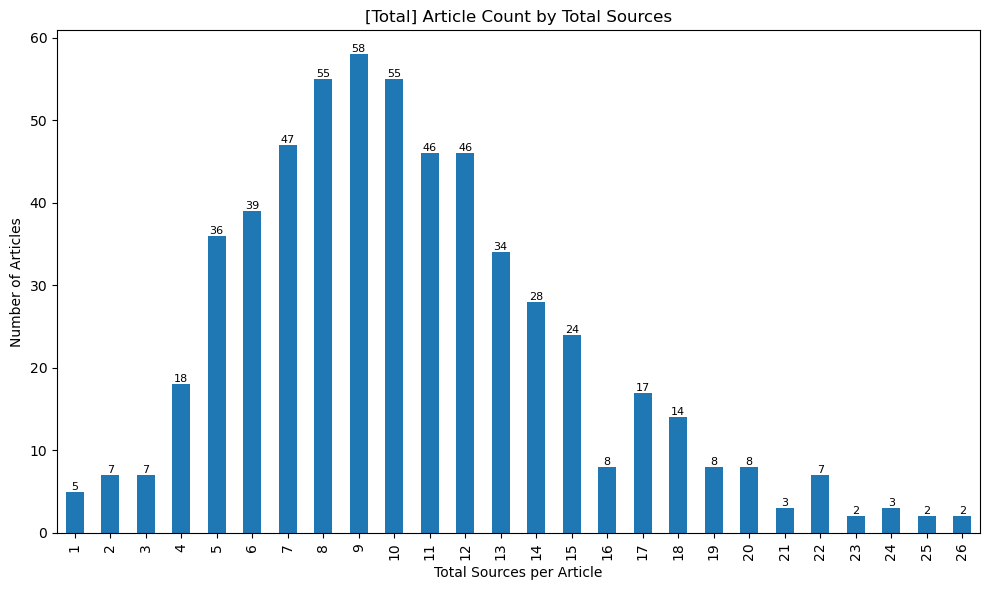

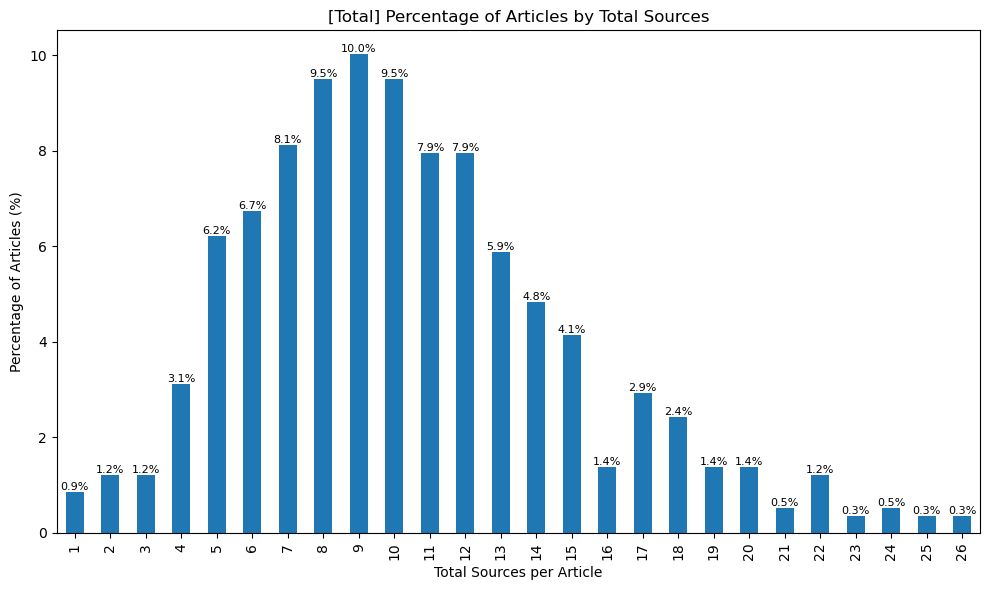

In [9]:
# Column that contains the total sources per article
column_to_analyze = 'Total'

# ---- Raw frequency counts ----
freq = df[column_to_analyze].value_counts().sort_index()

# ---- Plot raw counts ----
plt.figure(figsize=(10, 6))
ax = freq.plot(kind='bar')

plt.xlabel('Total Sources per Article')
plt.ylabel('Number of Articles')
plt.title('[Total] Article Count by Total Sources')

# Label bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

# ---- Plot percentages ----
percent = (freq / freq.sum()) * 100

plt.figure(figsize=(10, 6))
ax = percent.plot(kind='bar')

plt.xlabel('Total Sources per Article')
plt.ylabel('Percentage of Articles (%)')
plt.title('[Total] Percentage of Articles by Total Sources')

# Label bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

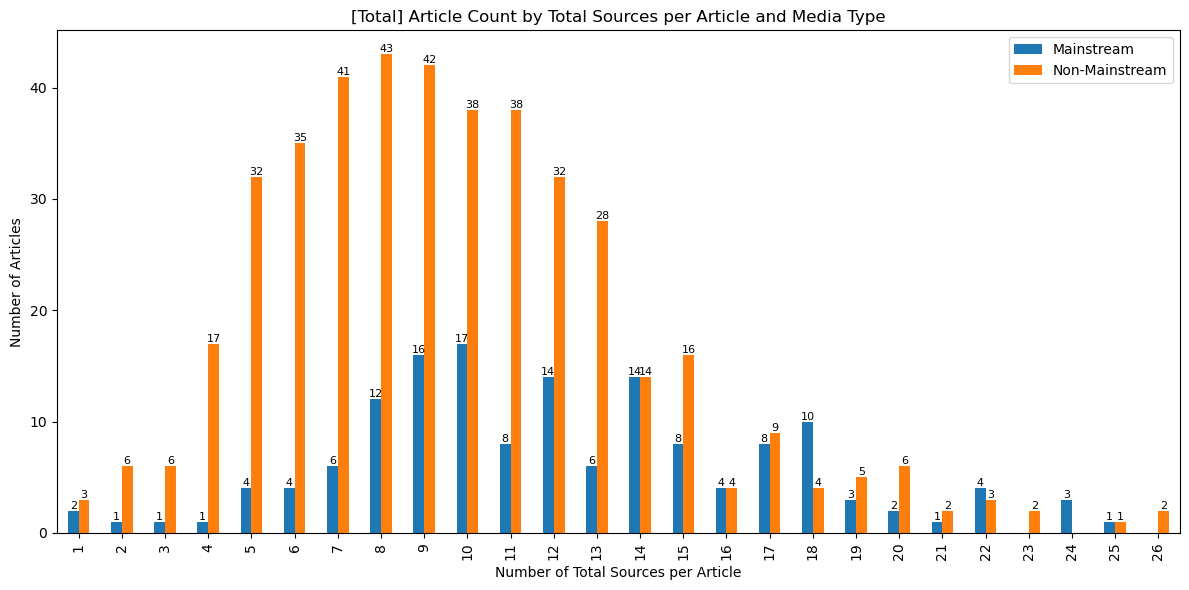

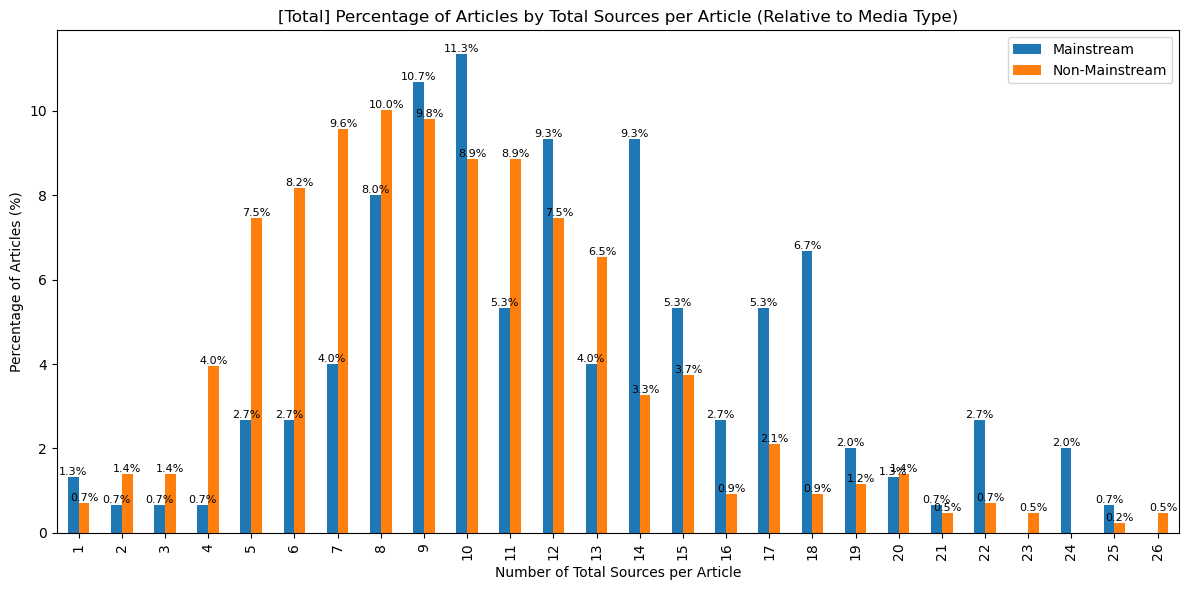


🔬 Statistical Test for 'Total Sources per Article' Between Mainstream and Non-Mainstream
  - Shapiro-Wilk p (Mainstream): 0.0223
  - Shapiro-Wilk p (Non-Mainstream): 0.0000
  ✅ Mann-Whitney U Test Result: statistic = 42327.500, p = 0.0000
  ❗ There is a **significant difference** in 'Total Sources per Article' between the groups.


In [14]:
plot_source_distribution(
    df,
    column_to_analyze='Total',
    label='Total Sources per Article',
    title_prefix='[Total] '
)

### based on entity type   
同篇 article、同個 entity type、所有人 = 看成一個 source

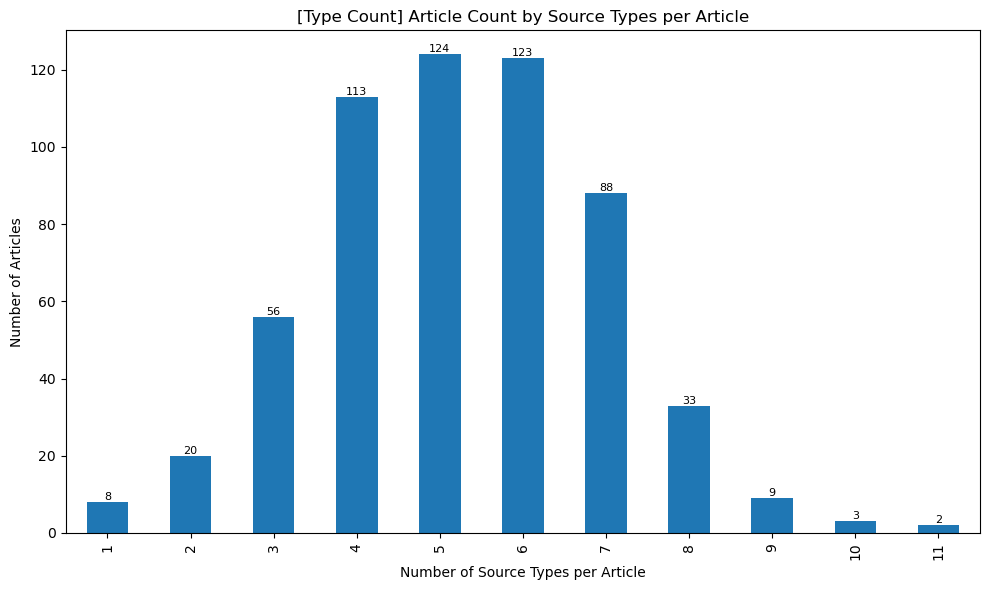

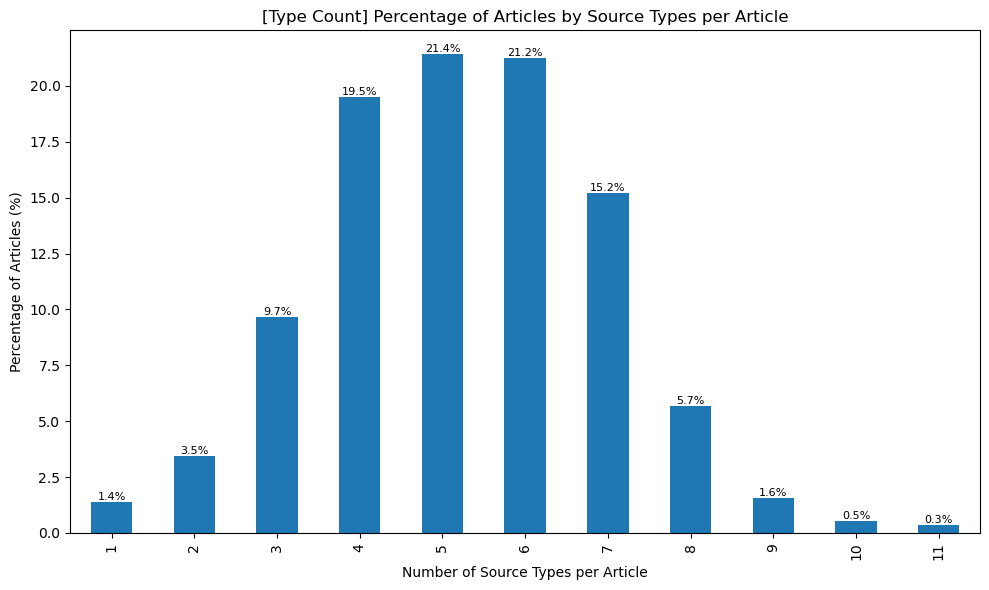

In [11]:
# 1. Compute how many different source types each article uses
df['Source_Type_Count'] = df[source_type_cols].gt(0).sum(axis=1)

# 2. Count frequencies
freq = df['Source_Type_Count'].value_counts().sort_index()

# ---- Plot raw counts ----
plt.figure(figsize=(10, 6))
ax = freq.plot(kind='bar')

plt.xlabel('Number of Source Types per Article')
plt.ylabel('Number of Articles')
plt.title('[Type Count] Article Count by Source Types per Article')

# Label bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

# ---- Plot percentages ----
percent = (freq / freq.sum()) * 100

plt.figure(figsize=(10, 6))
ax = percent.plot(kind='bar')

plt.xlabel('Number of Source Types per Article')
plt.ylabel('Percentage of Articles (%)')
plt.title('[Type Count] Percentage of Articles by Source Types per Article')

# Label bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()

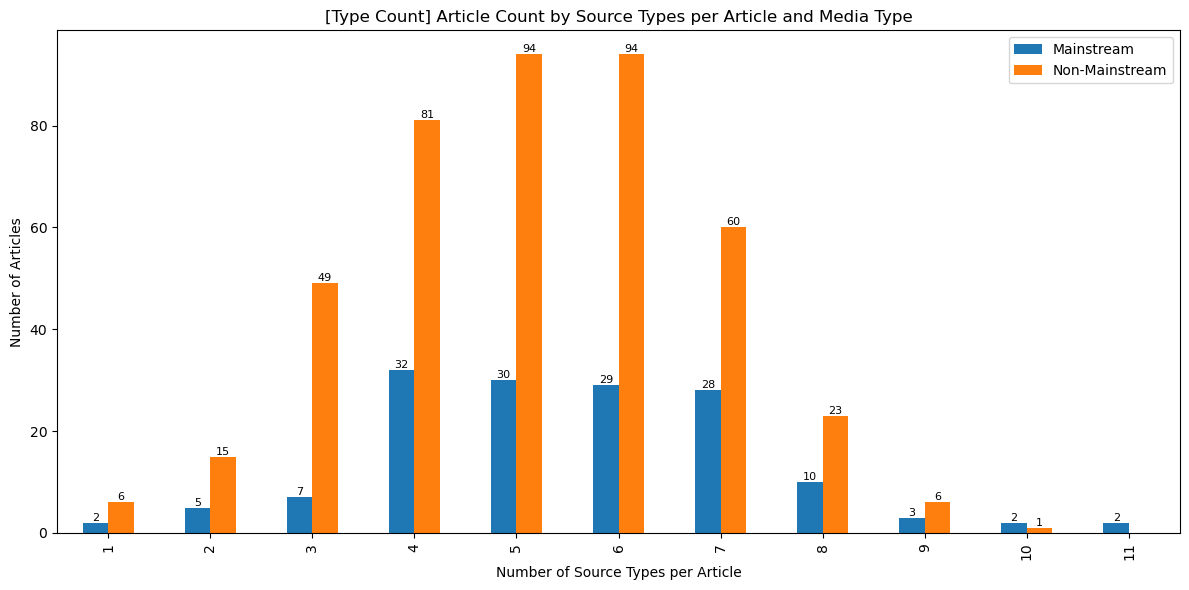

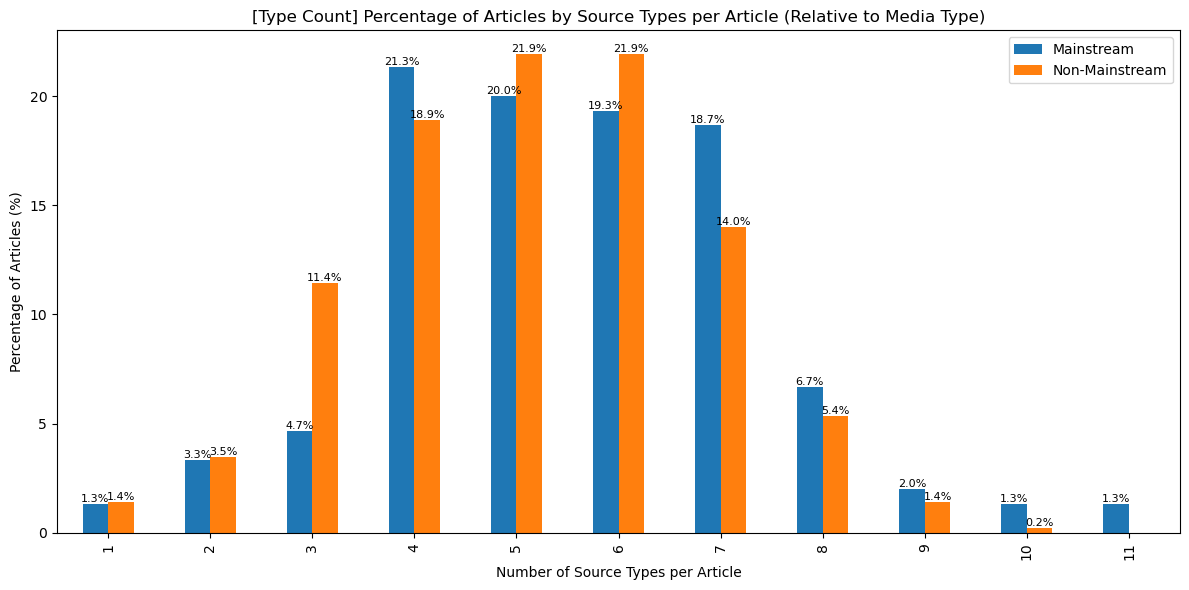


🔬 Statistical Test for 'Source Types per Article' Between Mainstream and Non-Mainstream
  - Shapiro-Wilk p (Mainstream): 0.0004
  - Shapiro-Wilk p (Non-Mainstream): 0.0000
  ✅ Mann-Whitney U Test Result: statistic = 35763.000, p = 0.0387
  ❗ There is a **significant difference** in 'Source Types per Article' between the groups.


In [17]:
df['Source_Type_Count'] = df[source_type_cols].gt(0).sum(axis=1)

# 2. Number of different types of sources per article
plot_source_distribution(
    df,
    column_to_analyze='Source_Type_Count',
    label='Source Types per Article',
    title_prefix='[Type Count] '
)

## Separate individuals and organizations

In [18]:
def plot_indiv_org_distribution(df, individual_cols, organization_cols, mode, perform_test=True):
    """
    Plots raw and percentage distributions of individual and organization sources per article,
    by media type (mainstream vs non-mainstream), for either counts or type diversity.
    Also performs statistical tests between media types for both source categories.

    Parameters:
    - df: pandas DataFrame
    - individual_cols: list of str, columns representing individual source types
    - organization_cols: list of str, columns representing organization source types
    - mode: 'count' for total counts, 'type' for number of types used
    - perform_test: bool, whether to perform statistical testing between media types
    """

    assert mode in ['count', 'type'], "mode must be either 'count' or 'type'"

    # Compute relevant columns
    if mode == 'count':
        df['Individual_Measure'] = df[individual_cols].sum(axis=1)
        df['Organization_Measure'] = df[organization_cols].sum(axis=1)
        measure_label = 'Sources per Article'
        title_suffix = 'Number of Sources'
    elif mode == 'type':
        df['Individual_Measure'] = df[individual_cols].gt(0).sum(axis=1)
        df['Organization_Measure'] = df[organization_cols].gt(0).sum(axis=1)
        measure_label = 'Different Source Types per Article'
        title_suffix = 'Number of Different Source Types'

    # Split by mainstream
    df_main = df[df['mainstream'] == 1]
    df_non = df[df['mainstream'] == 0]

    total_mainstream = df_main.shape[0]
    total_non_mainstream = df_non.shape[0]

    # Frequency counts
    indiv_main = df_main['Individual_Measure'].value_counts().sort_index()
    indiv_non = df_non['Individual_Measure'].value_counts().sort_index()
    org_main = df_main['Organization_Measure'].value_counts().sort_index()
    org_non = df_non['Organization_Measure'].value_counts().sort_index()

    # Raw count DataFrames
    indiv_df = pd.DataFrame({'Mainstream': indiv_main, 'Non-Mainstream': indiv_non}).fillna(0)
    org_df = pd.DataFrame({'Mainstream': org_main, 'Non-Mainstream': org_non}).fillna(0)

    # Percentage DataFrames
    indiv_pct_df = pd.DataFrame({
        'Mainstream': (indiv_main / total_mainstream) * 100,
        'Non-Mainstream': (indiv_non / total_non_mainstream) * 100
    }).fillna(0)

    org_pct_df = pd.DataFrame({
        'Mainstream': (org_main / total_mainstream) * 100,
        'Non-Mainstream': (org_non / total_non_mainstream) * 100
    }).fillna(0)

    # --- PLOT HELPERS ---
    def plot_bar(df_plot, xlabel, ylabel, title, percentage=False):
        ax = df_plot.plot(kind='bar', figsize=(12, 6))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        height,
                        f'{height:.1f}%' if percentage else f'{int(height)}',
                        ha='center',
                        va='bottom',
                        fontsize=8
                    )
        plt.tight_layout()
        plt.show()

    # --- PLOTS ---
    plot_bar(indiv_df, f'Number of {measure_label} (Individuals)', 'Number of Articles',
             f'Article Count by {title_suffix} (Individuals)')
    plot_bar(org_df, f'Number of {measure_label} (Organizations)', 'Number of Articles',
             f'Article Count by {title_suffix} (Organizations)')
    plot_bar(indiv_pct_df, f'Number of {measure_label} (Individuals)', 'Percentage of Articles (%)',
             f'Percentage of Articles by {title_suffix} (Individuals)', percentage=True)
    plot_bar(org_pct_df, f'Number of {measure_label} (Organizations)', 'Percentage of Articles (%)',
             f'Percentage of Articles by {title_suffix} (Organizations)', percentage=True)

    # --- STATISTICAL TESTING ---
    if perform_test:
        def run_stat_test(group1, group2, label):
            # Check normality
            p1 = shapiro(group1)[1] if len(group1) >= 3 else 0
            p2 = shapiro(group2)[1] if len(group2) >= 3 else 0
            normal = p1 > 0.05 and p2 > 0.05

            if normal:
                stat, pval = ttest_ind(group1, group2)
                test = "T-test"
            else:
                stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
                test = "Mann-Whitney U Test"

            print(f"\n🔬 {test} for {label}")
            print(f"  - p-value: {pval:.4f}")
            if pval < 0.05:
                print(f"  ❗ Significant difference in {label} between media types.")
            else:
                print(f"  ✅ No significant difference in {label} between media types.")

        run_stat_test(df_main['Individual_Measure'], df_non['Individual_Measure'], f'Individual {title_suffix}')
        run_stat_test(df_main['Organization_Measure'], df_non['Organization_Measure'], f'Organization {title_suffix}')


### based on person  
同篇 article、同個 entity type、不同人 = 不同 sources

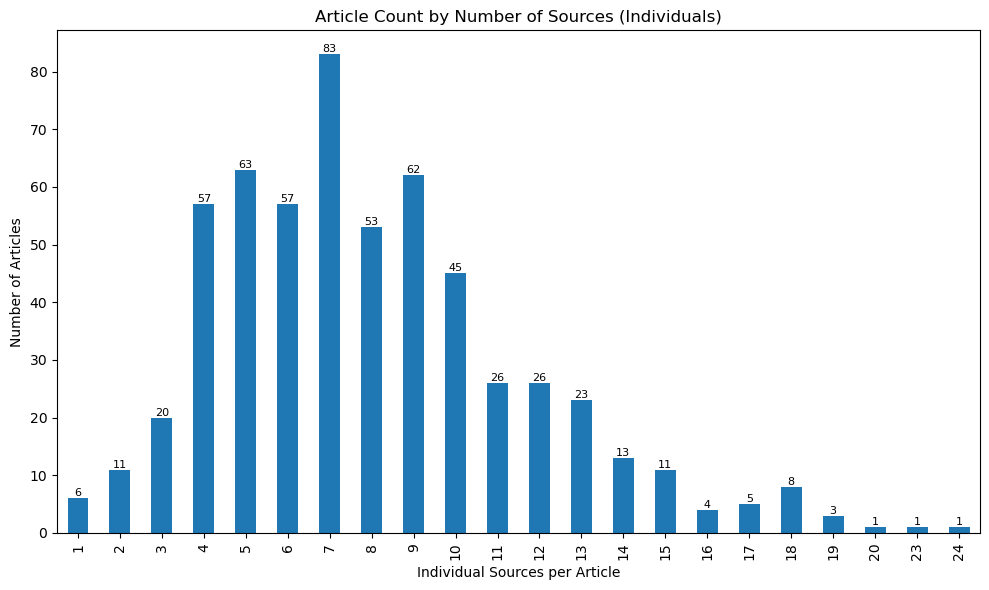

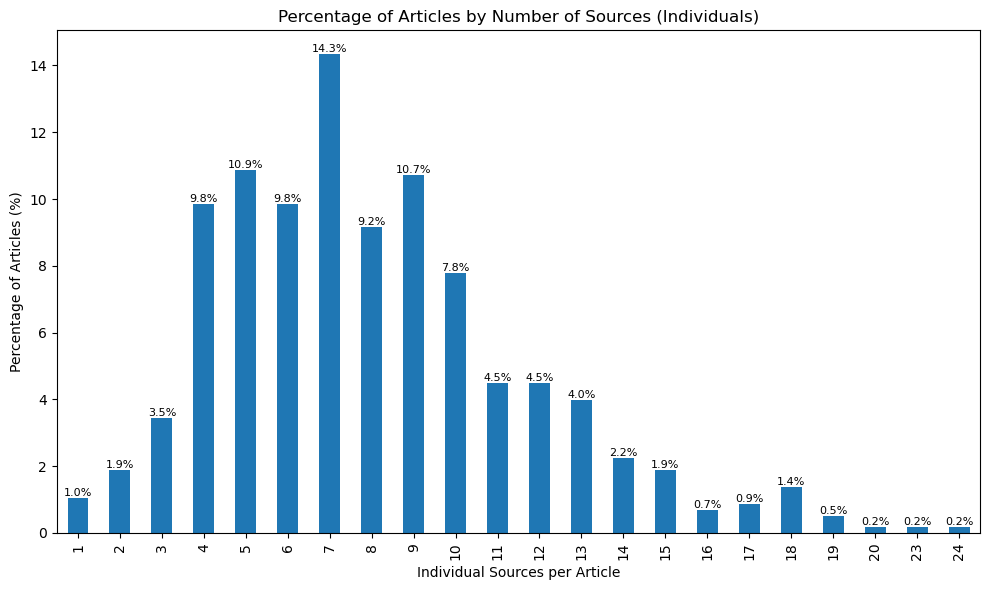

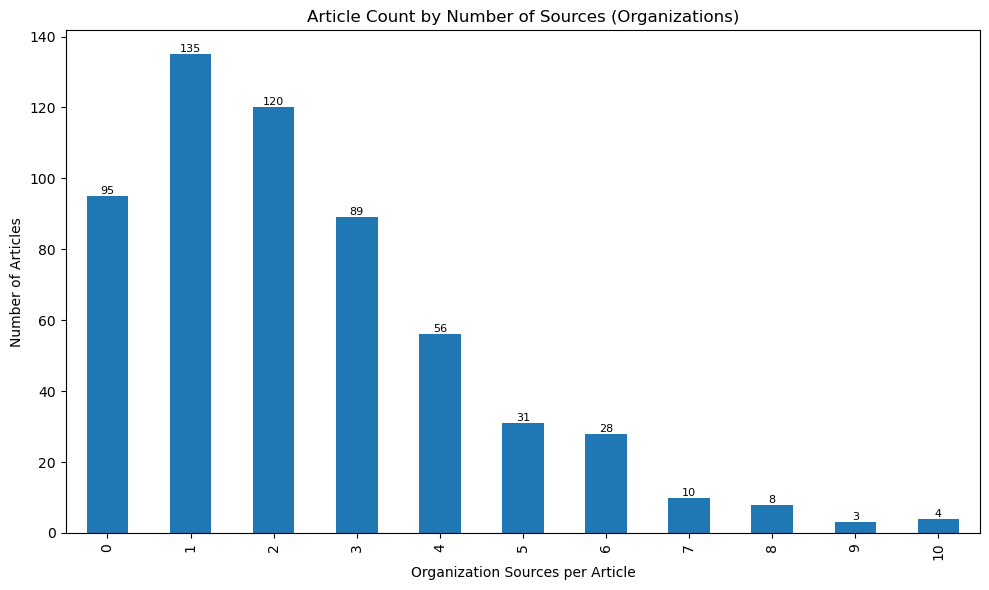

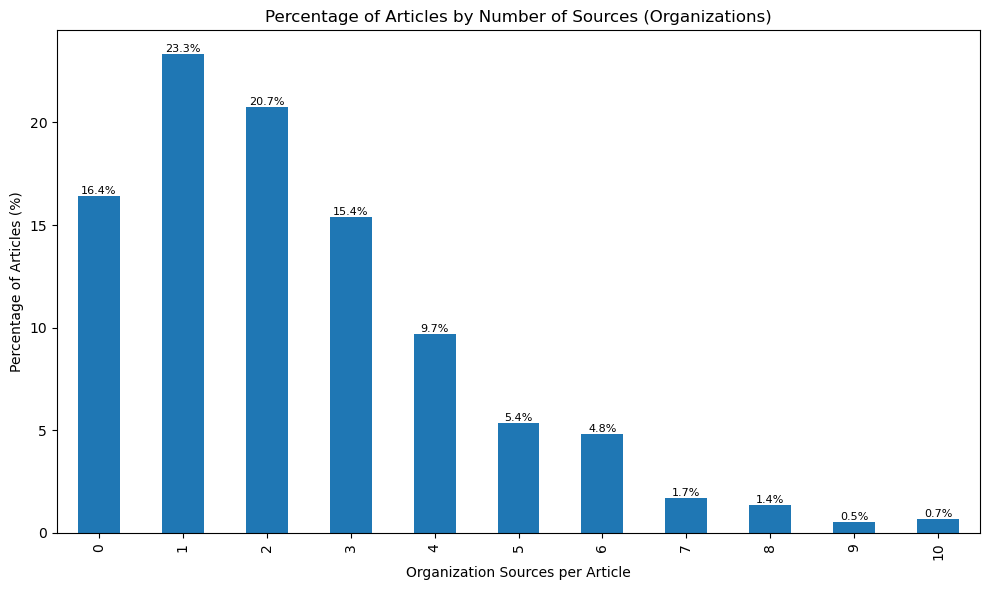

In [25]:
def plot_distribution(series, xlabel, title, percentage=False):
    if percentage:
        values = (series / series.sum()) * 100
    else:
        values = series

    plt.figure(figsize=(10, 6))
    ax = values.plot(kind='bar')

    plt.xlabel(xlabel)
    plt.ylabel("Percentage of Articles (%)" if percentage else "Number of Articles")
    plt.title(title)

    # label bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.1f}%' if percentage else f'{int(height)}',
            ha='center', va='bottom', fontsize=8
        )

    plt.tight_layout()
    plt.show()
    
df['Individual_Measure'] = df[individual_cols].sum(axis=1)
indiv_label = "Individual Sources per Article"
indiv_title = "by Number of Sources (Individuals)"

df['Organization_Measure'] = df[organization_cols].sum(axis=1)
org_label = "Organization Sources per Article"
org_title = "by Number of Sources (Organizations)"

indiv_freq = df['Individual_Measure'].value_counts().sort_index()

plot_distribution(
    indiv_freq,
    indiv_label,
    f"Article Count {indiv_title}"
)

plot_distribution(
    indiv_freq,
    indiv_label,
    f"Percentage of Articles {indiv_title}",
    percentage=True
)

# ------------------------------------------------------
# ORGANIZATION DISTRIBUTIONS
# ------------------------------------------------------
org_freq = df['Organization_Measure'].value_counts().sort_index()

plot_distribution(
    org_freq,
    org_label,
    f"Article Count {org_title}"
)

plot_distribution(
    org_freq,
    org_label,
    f"Percentage of Articles {org_title}",
    percentage=True
)

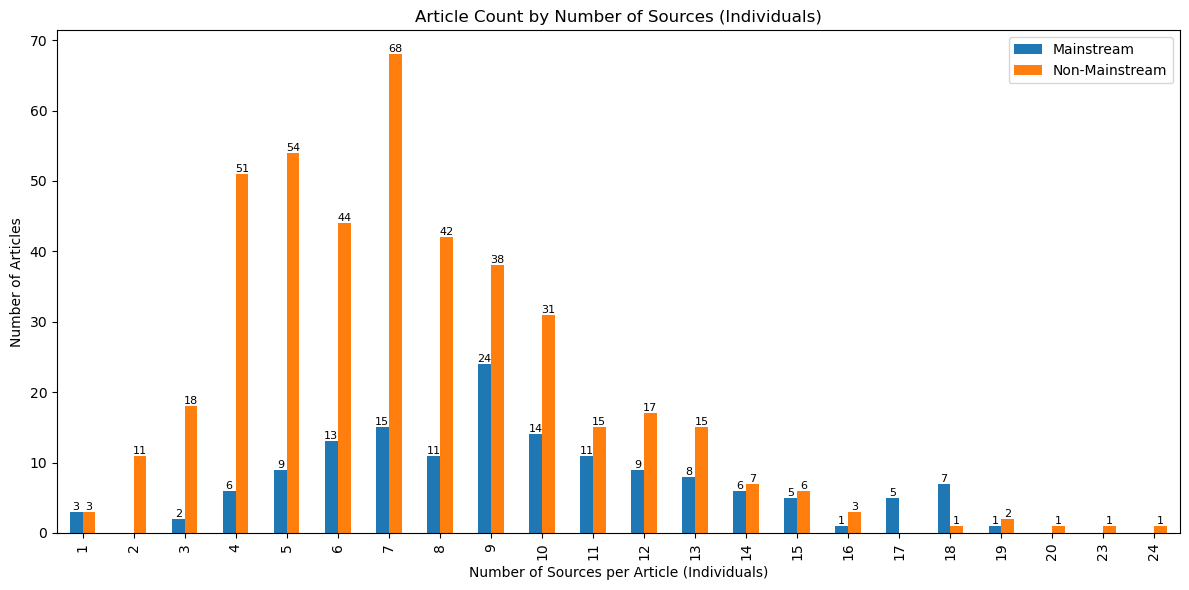

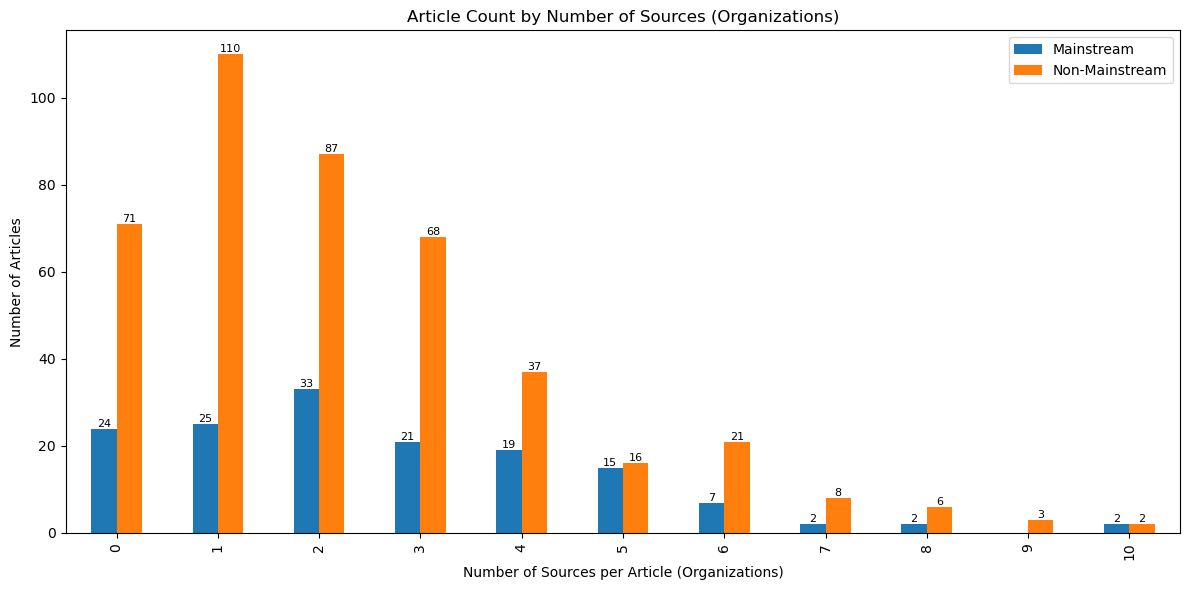

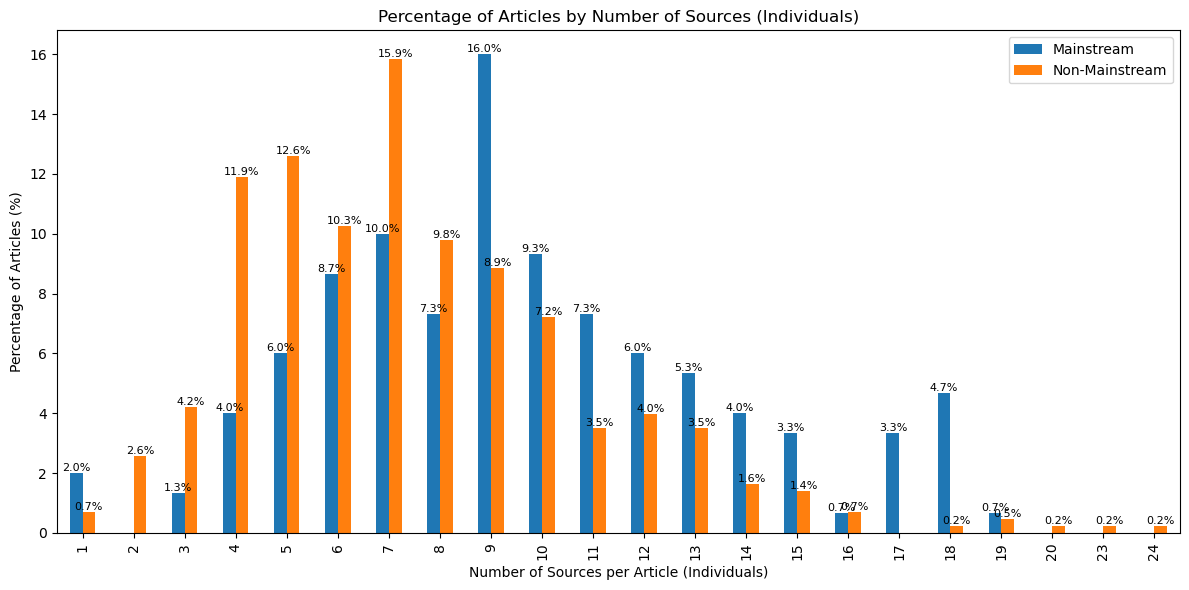

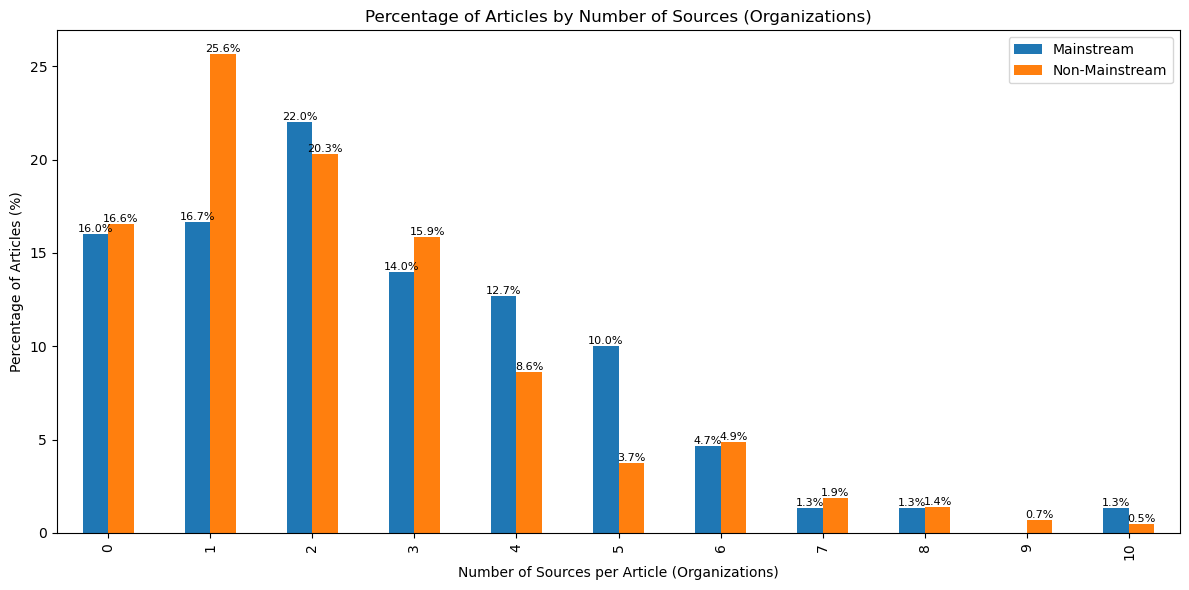


🔬 Mann-Whitney U Test for Individual Number of Sources
  - p-value: 0.0000
  ❗ Significant difference in Individual Number of Sources between media types.

🔬 Mann-Whitney U Test for Organization Number of Sources
  - p-value: 0.0537
  ✅ No significant difference in Organization Number of Sources between media types.


In [19]:
plot_indiv_org_distribution(
    df,
    individual_cols=individual_cols,
    organization_cols=organization_cols,
    mode='count'  # total number of sources
)

### based on entity type  
同篇 article、同個 entity type、所有人 = 看成一個 source

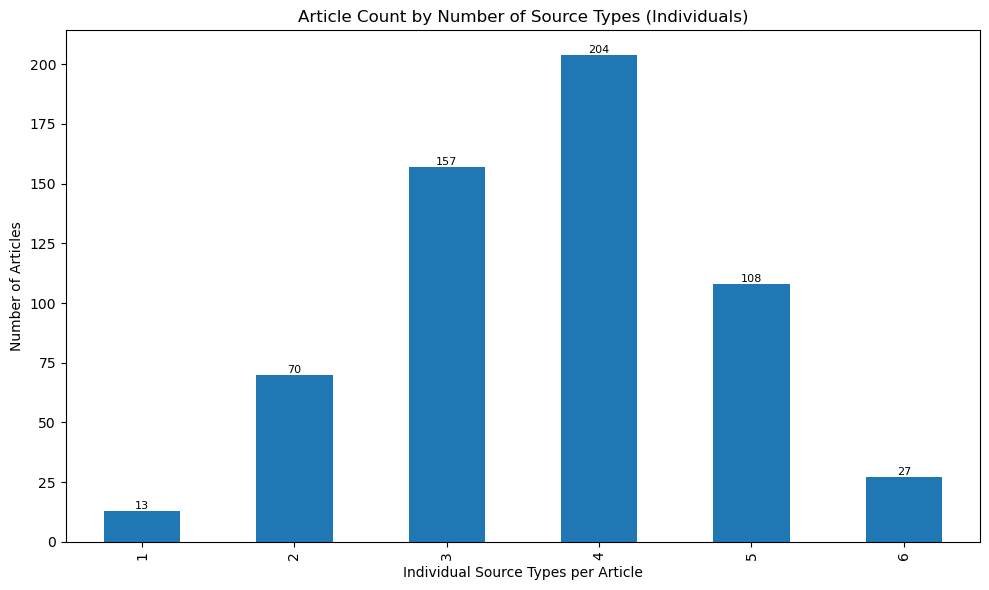

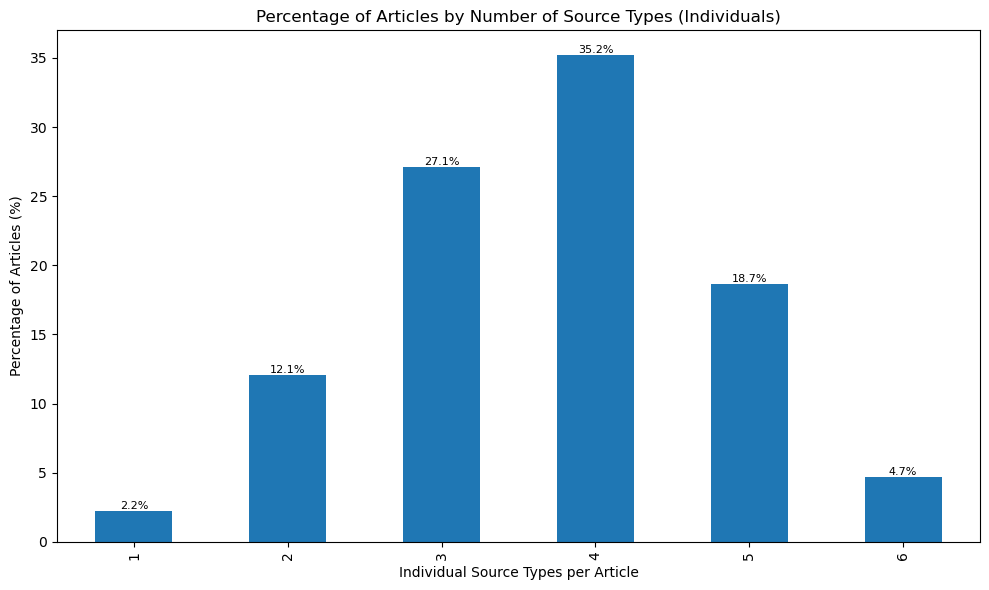

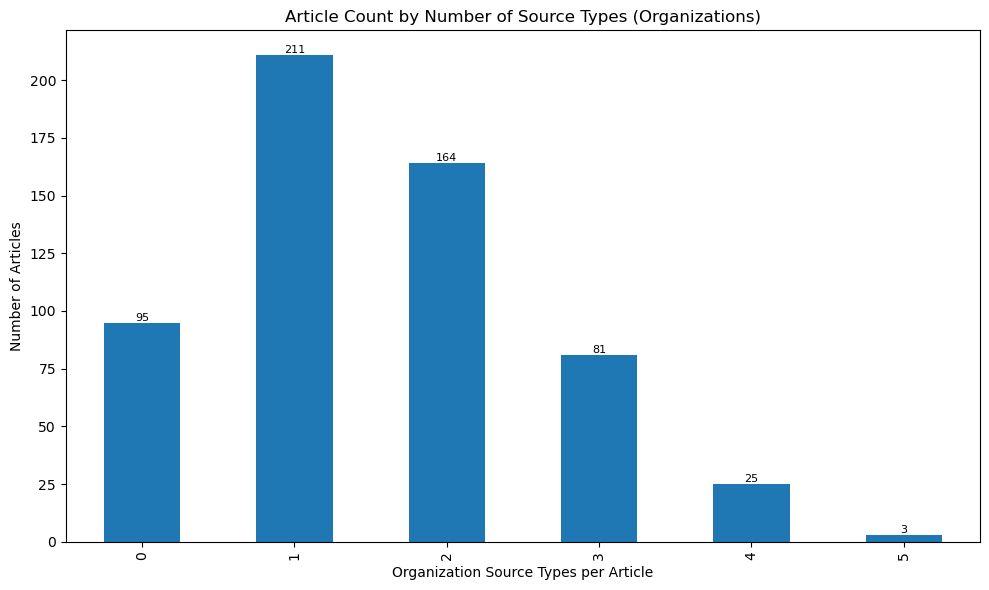

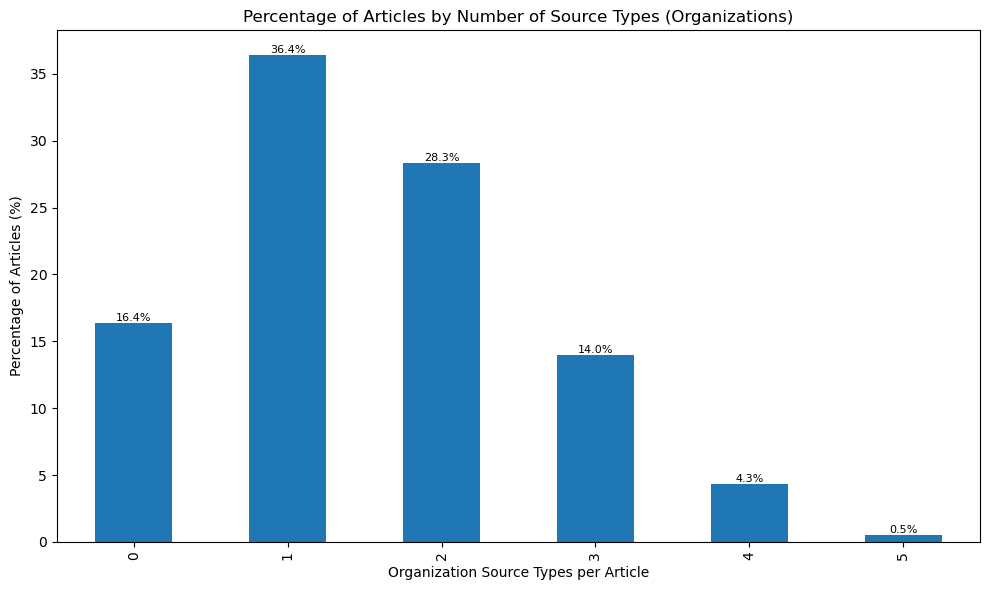

In [21]:
df['Individual_Measure'] = df[individual_cols].gt(0).sum(axis=1)
indiv_label = "Individual Source Types per Article"
indiv_title = "by Number of Source Types (Individuals)"

df['Organization_Measure'] = df[organization_cols].gt(0).sum(axis=1)
org_label = "Organization Source Types per Article"
org_title = "by Number of Source Types (Organizations)"

indiv_freq = df['Individual_Measure'].value_counts().sort_index()

plot_distribution(
    indiv_freq,
    indiv_label,
    f"Article Count {indiv_title}"
)

plot_distribution(
    indiv_freq,
    indiv_label,
    f"Percentage of Articles {indiv_title}",
    percentage=True
)

# ------------------------------------------------------
# ORGANIZATION DISTRIBUTIONS
# ------------------------------------------------------
org_freq = df['Organization_Measure'].value_counts().sort_index()

plot_distribution(
    org_freq,
    org_label,
    f"Article Count {org_title}"
)

plot_distribution(
    org_freq,
    org_label,
    f"Percentage of Articles {org_title}",
    percentage=True
)

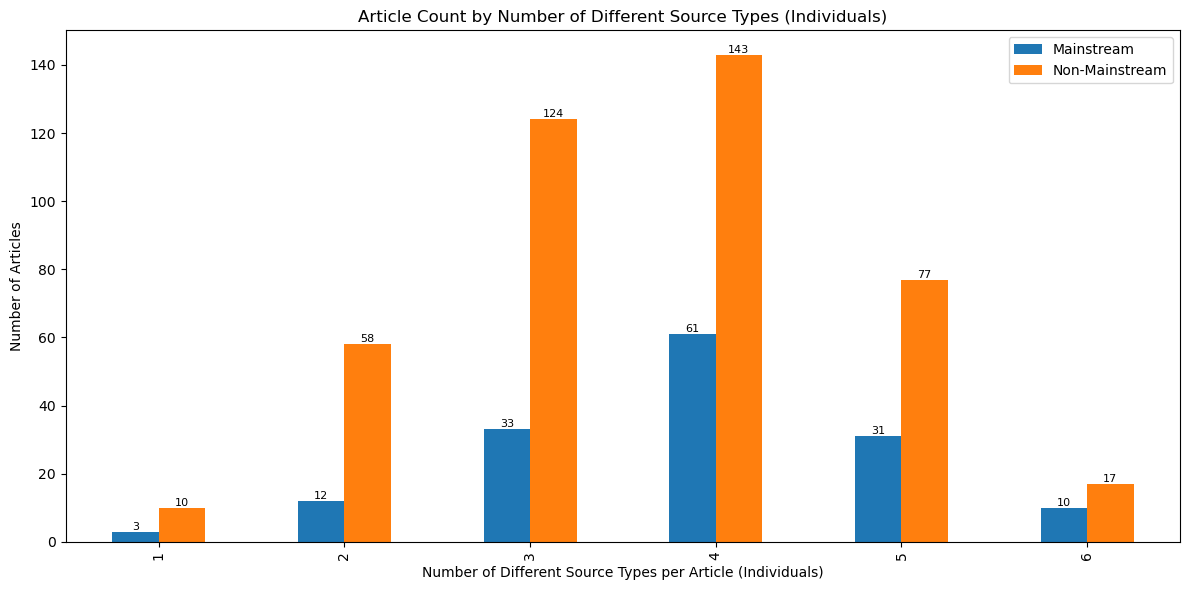

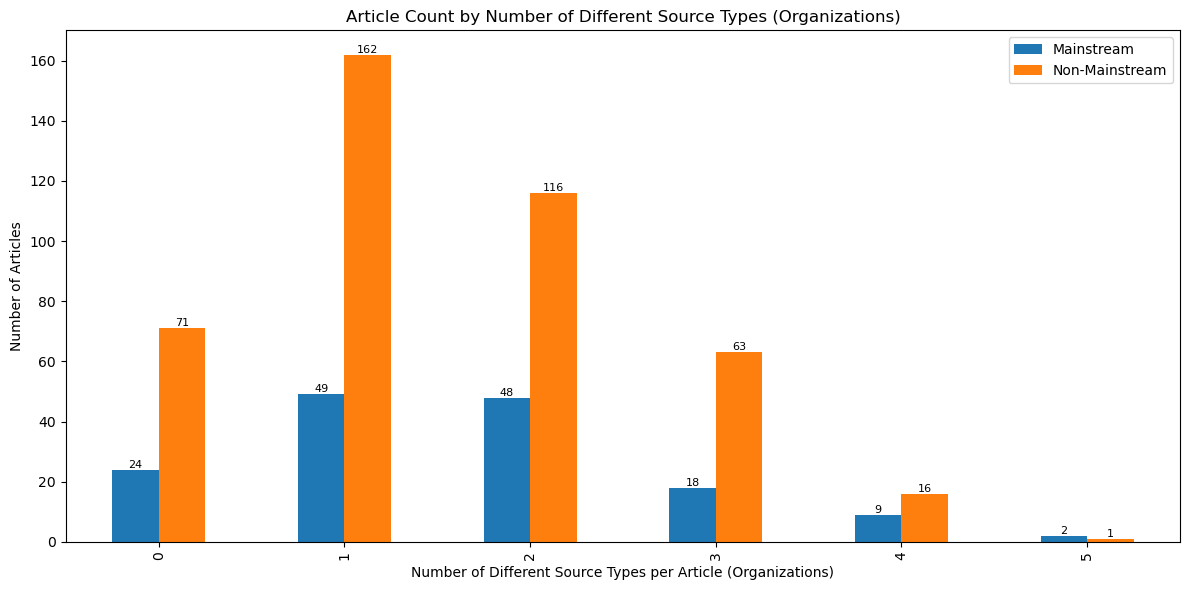

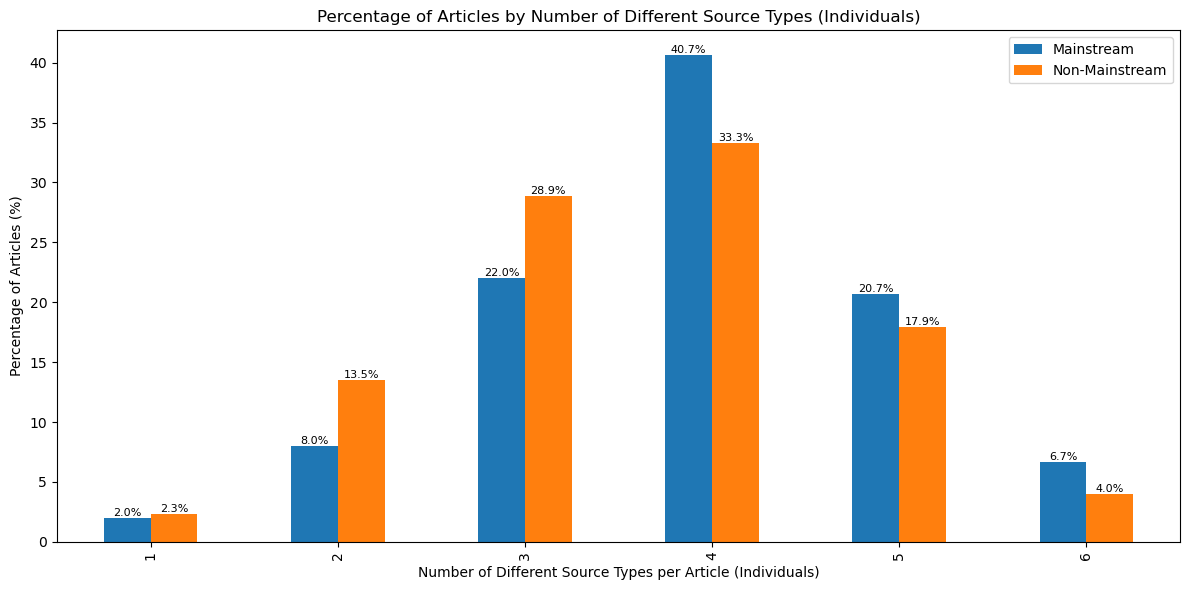

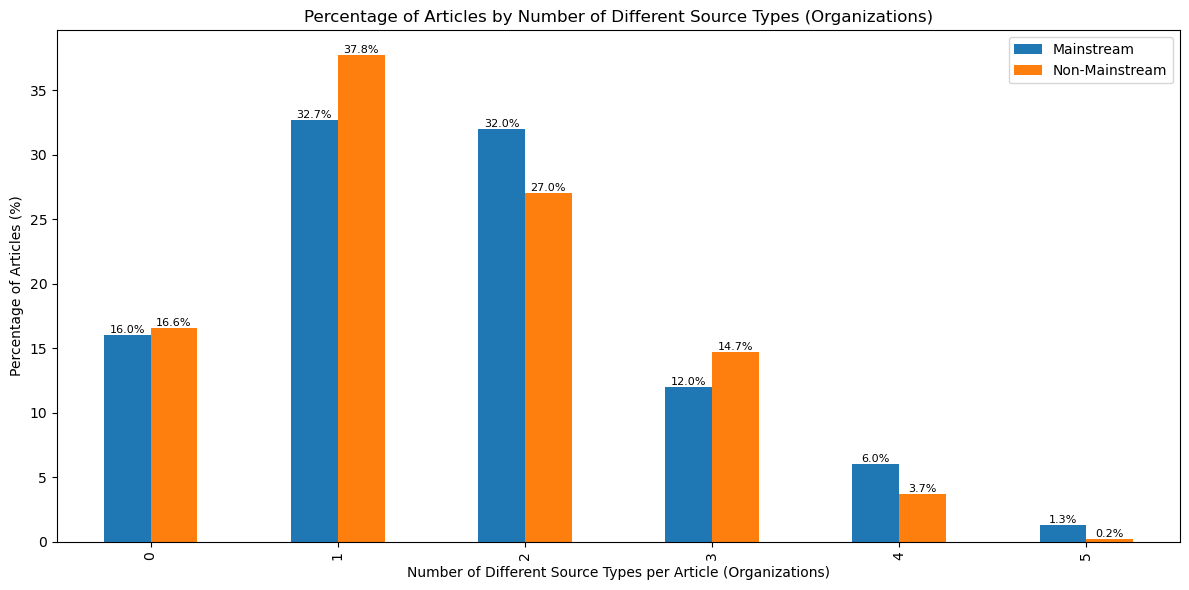


🔬 Mann-Whitney U Test for Individual Number of Different Source Types
  - p-value: 0.0087
  ❗ Significant difference in Individual Number of Different Source Types between media types.

🔬 Mann-Whitney U Test for Organization Number of Different Source Types
  - p-value: 0.3512
  ✅ No significant difference in Organization Number of Different Source Types between media types.


In [20]:
plot_indiv_org_distribution(
    df,
    individual_cols=individual_cols,
    organization_cols=organization_cols,
    mode='type'  # number of types
)

## Significant difference (好像不用)

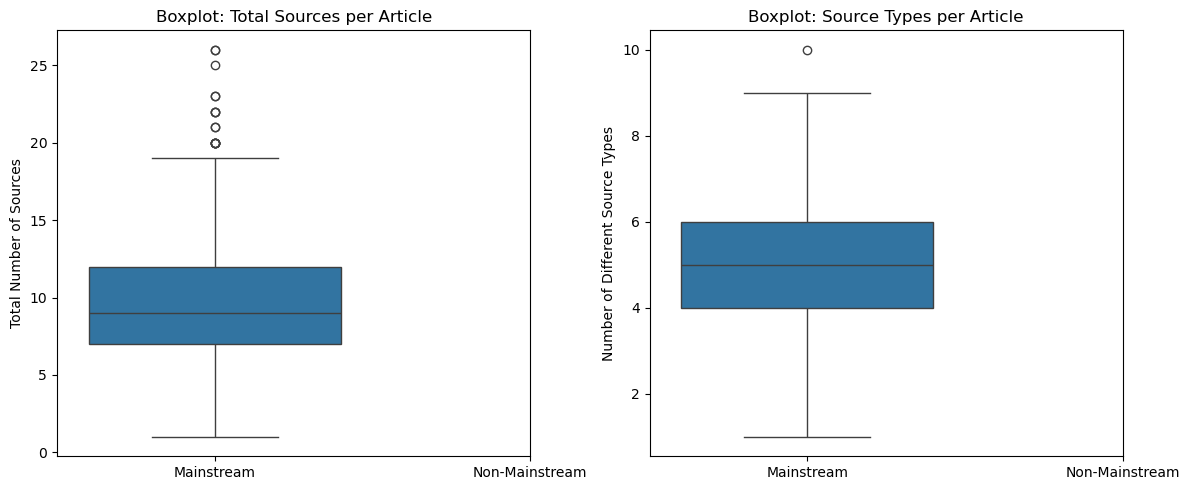

Normality Tests:
Mainstream Total: p = 0.0223 (not normal)
Non-Mainstream Total: p = 0.0000 (not normal)
Mainstream Types: p = 0.0004 (not normal)
Non-Mainstream Types: p = 0.0000 (not normal)

Statistical Test: Total Sources per Article
Mann-Whitney U Test: U = 42327.500, p = 0.0000

Statistical Test: Number of Different Source Types
Mann-Whitney U Test: U = 35763.000, p = 0.0387


In [11]:
# 1. Ensure Source_Type_Count column is calculated
df['Source_Type_Count'] = df[source_type_cols].gt(0).sum(axis=1)

# 2. Split data into two groups
mainstream_total = df[df['mainstream'] == 1]['Total']
non_mainstream_total = df[df['mainstream'] == 0]['Total']

mainstream_types = df[df['mainstream'] == 1]['Source_Type_Count']
non_mainstream_types = df[df['mainstream'] == 0]['Source_Type_Count']

# 3. Visual Comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=[mainstream_total, non_mainstream_total])
plt.xticks([0, 1], ['Mainstream', 'Non-Mainstream'])
plt.title('Boxplot: Total Sources per Article')
plt.ylabel('Total Number of Sources')

plt.subplot(1, 2, 2)
sns.boxplot(data=[mainstream_types, non_mainstream_types])
plt.xticks([0, 1], ['Mainstream', 'Non-Mainstream'])
plt.title('Boxplot: Source Types per Article')
plt.ylabel('Number of Different Source Types')

plt.tight_layout()
plt.show()

# 4. Test for normality (Shapiro-Wilk test)
print("Normality Tests:")
for label, data in {
    "Mainstream Total": mainstream_total,
    "Non-Mainstream Total": non_mainstream_total,
    "Mainstream Types": mainstream_types,
    "Non-Mainstream Types": non_mainstream_types
}.items():
    stat, p = shapiro(data)
    print(f"{label}: p = {p:.4f} {'(normal)' if p > 0.05 else '(not normal)'}")

# 5. Statistical Test (t-test or Mann-Whitney depending on normality)

# --- Total Number of Sources ---
print("\nStatistical Test: Total Sources per Article")
if (shapiro(mainstream_total).pvalue > 0.05) and (shapiro(non_mainstream_total).pvalue > 0.05):
    # Use t-test
    stat, p = ttest_ind(mainstream_total, non_mainstream_total)
    print(f"T-test: t = {stat:.3f}, p = {p:.4f}")
else:
    # Use Mann-Whitney U
    stat, p = mannwhitneyu(mainstream_total, non_mainstream_total, alternative='two-sided')
    print(f"Mann-Whitney U Test: U = {stat:.3f}, p = {p:.4f}")

# --- Number of Different Source Types ---
print("\nStatistical Test: Number of Different Source Types")
if (shapiro(mainstream_types).pvalue > 0.05) and (shapiro(non_mainstream_types).pvalue > 0.05):
    stat, p = ttest_ind(mainstream_types, non_mainstream_types)
    print(f"T-test: t = {stat:.3f}, p = {p:.4f}")
else:
    stat, p = mannwhitneyu(mainstream_types, non_mainstream_types, alternative='two-sided')
    print(f"Mann-Whitney U Test: U = {stat:.3f}, p = {p:.4f}")
